In [116]:
import tensorflow as tf
import os

In [117]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [118]:
import filetype
import cv2

In [119]:
dataDir = "data"
imageTypes = ["jpg", "jpeg", "png", "bmp"]

In [120]:
for image_class in os.listdir(dataDir):
    for image in os.listdir(os.path.join(dataDir, image_class)):
        imagePath = os.path.join(dataDir, image_class, image)
        try: # Check if image is corrupted
            img = cv2.imread(imagePath)
            kind = filetype.guess(imagePath)
            if kind is None or kind.extension not in imageTypes:
                print(f'Image {imagePath} is of type {kind}. Should be in {imageTypes}')
                os.remove(imagePath)
        except Exception as e:
            print('Issue with image {}'.format(imagePath))
            os.remove(imagePath)

In [121]:
max_images = 1000

In [122]:
for image_class in os.listdir(dataDir):
    class_dir = os.path.join(dataDir, image_class)
    if not os.path.isdir(class_dir):
        continue  # skip if not a folder

    images = os.listdir(class_dir)

    if len(images) > max_images:
        print(f'Too many images in {image_class} ({len(images)}). Removing extras...')

        # delete everything after the first 100
        for idx, image in enumerate(images):
            if idx >= max_images:
                os.remove(os.path.join(class_dir, image))

In [123]:
import numpy as np
import matplotlib.pyplot as plt

In [124]:

data = tf.keras.utils.image_dataset_from_directory('data')

Found 2000 files belonging to 2 classes.


In [125]:
data_iterator = data.as_numpy_iterator()

In [126]:
batch = data_iterator.next()

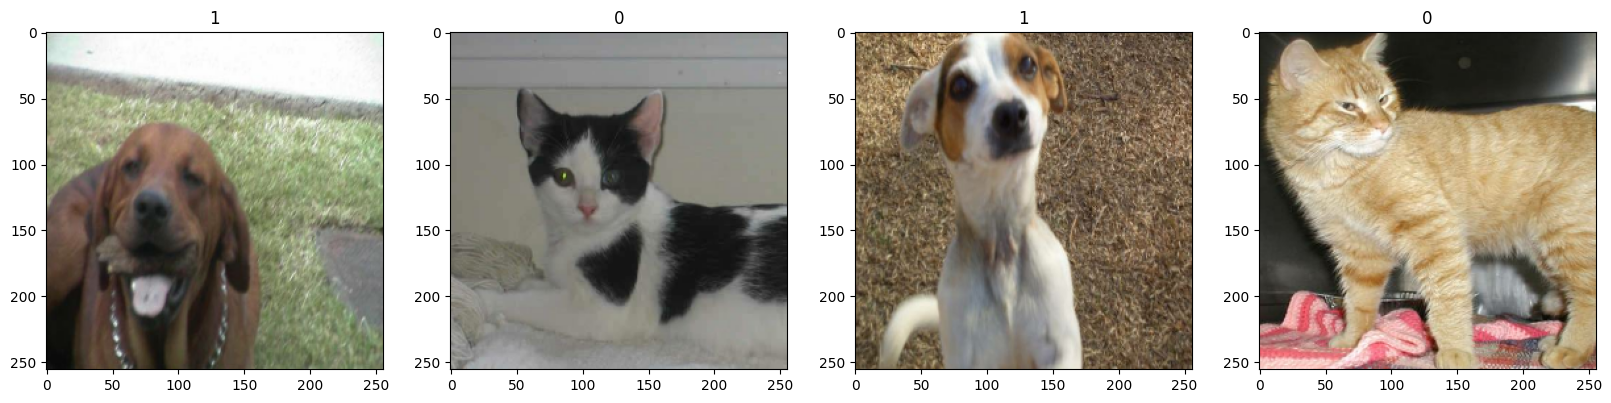

In [127]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [128]:
data = data.map(lambda x,y: (x/255, y))

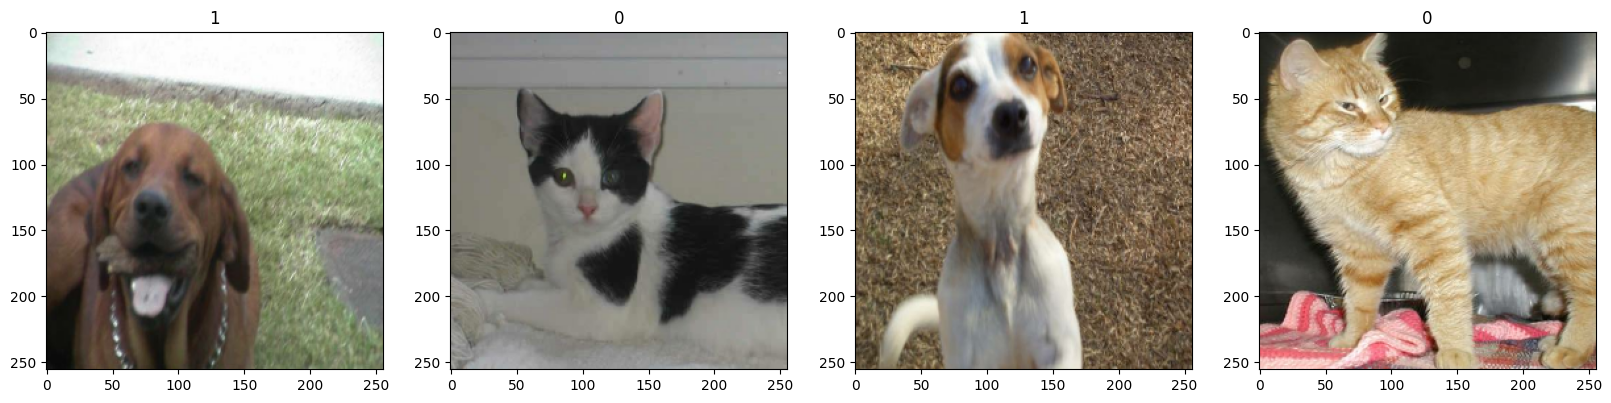

In [129]:
bacth = data.as_numpy_iterator().next()
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [130]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [131]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [132]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [133]:
model = Sequential()
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D()) 
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))



c:\Users\gwbar\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [134]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [135]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 254, 254, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 125, 125, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 60, 60, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 30, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 14400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │     3,686,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,696,625 (14.10 MB)

 Trainable params: 3,696,625 (14.10 MB)

 Non-trainable params: 0 (0.00 B)

In [136]:
logdir='logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [137]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20


44/44 ━━━━━━━━━━━━━━━━━━━━ 14s 278ms/step - accuracy: 0.5135 - loss: 0.7374 - val_accuracy: 0.4896 - val_loss: 0.6884
Epoch 2/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 10s 228ms/step - accuracy: 0.5625 - loss: 0.6839 - val_accuracy: 0.5755 - val_loss: 0.6838
Epoch 3/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 10s 223ms/step - accuracy: 0.6271 - loss: 0.6594 - val_accuracy: 0.5443 - val_loss: 0.6801
Epoch 4/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 10s 224ms/step - accuracy: 0.7010 - loss: 0.5852 - val_accuracy: 0.7109 - val_loss: 0.5808
Epoch 5/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 10s 215ms/step - accuracy: 0.7571 - loss: 0.4857 - val_accuracy: 0.6693 - val_loss: 0.6394
Epoch 6/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 10s 218ms/step - accuracy: 0.8288 - loss: 0.3736 - val_accuracy: 0.7396 - val_loss: 0.6227
Epoch 7/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 10s 228ms/step - accuracy: 0.8835 - loss: 0.2734 - val_accuracy: 0.7031 - val_loss: 0.8029
Epoch 8/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 10s 216ms/step - accuracy: 0.9368 - loss: 0.1802 - val_accuracy: 0.742

In [138]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [139]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


In [140]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(0.7425743, shape=(), dtype=float32) tf.Tensor(0.8064516, shape=(), dtype=float32) tf.Tensor(0.7708333, shape=(), dtype=float32)


In [141]:
from tensorflow.keras.models import load_model

In [142]:
model.save(os.path.join('models','imageClassifier1.h5'))

In [ ]:
new_model = load_model('imageClassifier1.h5')
new_model.predict(np.expand_dims(resize/255, 0))

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'imageClassifier1.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)